# Import the drive since the dataset is stored there

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/MyDrive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import and install relevant packages

In [ ]:
!pip install nibabel -q
!pip install tqdm -q
!pip install segmentation-models-pytorch-3d -q
!pip install torchinfo -q
!pip install livelossplot -q
!pip install torchmetrics -q
!pip install tensorboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random
# import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.cuda import amp

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import gc

import segmentation_models_pytorch_3d as smp

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

# Set device for CUDA if available\
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
scaler = MinMaxScaler()

# Build the Dataset class

In [ ]:
# def resize_image(image, target_size):

#   resized_image = F.interpolate(image.unsqueeze(0), size=target_size, mode='trilinear', align_corners=False)
#   return resized_image.squeeze(0)

# def resize_label(label, target_size):

#   resized_label = F.interpolate(label.unsqueeze(0).float(), size=target_size, mode='nearest')
#   return resized_label.squeeze(0).squeeze(0).long()


class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing subject folders.
            transform (callable, optional): Transformation to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # self.target_size = target_size
        # Assumes folder names like 'BraTS-GLI-00000-000', etc.
        self.subject_dirs = sorted([
            os.path.join(root_dir, d)
            for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

    def __len__(self):
        return len(self.subject_dirs)

    def __getitem__(self, idx):
        sub_dir = self.subject_dirs[idx]
        files = os.listdir(sub_dir)
        # Find the necessary files by modality identifier
        seg_file  = [f for f in files if 'seg.nii.gz' in f][0]
        t1c_file  = [f for f in files if 't1c.nii.gz' in f][0]
        # t1n_file  = [f for f in files if 't1n.nii.gz' in f][0]
        t2f_file  = [f for f in files if 't2f.nii.gz' in f][0]
        t2w_file  = [f for f in files if 't2w.nii.gz' in f][0]

        # Load images using nibabel
        temp_mask  = nib.load(os.path.join(sub_dir, seg_file)).get_fdata()

        temp_t1c  = nib.load(os.path.join(sub_dir, t1c_file)).get_fdata()
        temp_t1c = scaler.fit_transform(temp_t1c.reshape(-1, temp_t1c.shape[-1])).reshape(temp_t1c.shape)

        #
        # t1n  = nib.load(os.path.join(sub_dir, t1n_file)).get_fdata()
        temp_t2f  = nib.load(os.path.join(sub_dir, t2f_file)).get_fdata()
        temp_t2f = scaler.fit_transform(temp_t2f.reshape(-1, temp_t2f.shape[-1])).reshape(temp_t2f.shape)

        temp_t2w  = nib.load(os.path.join(sub_dir, t2w_file)).get_fdata()
        temp_t2w = scaler.fit_transform(temp_t2w.reshape(-1, temp_t2w.shape[-1])).reshape(temp_t2w.shape)

        # Stack modalities into a (C, H, W, D) volume (channels: t1c, t1n, t2f, t2w)
        # image = np.stack([t1c, t1n, t2f, t2w], axis=0).astype(np.float32)
        temp_image = np.stack([temp_t2f, temp_t1c, temp_t2w], axis=3)
        image = temp_image[27:155, 45:173, 27:155]
        image = torch.from_numpy(image).permute(3, 2, 0, 1)

        temp_mask = temp_mask[27:155, 45:173, 27:155]
        temp_mask = F.one_hot(torch.tensor(temp_mask, dtype=torch.long), num_classes = 4)
        mask = temp_mask.permute(3, 2, 0, 1)
        # mask = temp_mask

        # # Per-channel z-score normalization
        # for i in range(image.shape[0]):
        #     mean = np.mean(image[i])
        #     std = np.std(image[i]) if np.std(image[i]) > 0 else 1.0
        #     image[i] = (image[i] - mean) / std

        # if self.transform:
        #     image = self.transform(image)
        #     mask = self.transform(mask)

        return {'image': image, 'label': mask}


# Get the dataset splits and the dataloaders

In [ ]:
from torch.utils.data import random_split
# Set the dataset path (modify to your location)
train_dataset_path = '/content/drive/MyDrive/BraTS2025-GLI-PRE-Challenge-TrainingData'
test_dataset_path = '/content/drive/MyDrive/BraTS2025-GLI-PRE-Challenge-ValidationData'

# Create the full dataset (full-volume each sample)
# target_size = (16, 256, 256)
train_dataset = BraTSDataset(train_dataset_path)
test_dataset = BraTSDataset(test_dataset_path)

# Now split the subset into train/validation/test splits (80/10/10 split)
total_samples = len(train_dataset)
train_len = int(0.8 * total_samples)
val_len   = total_samples - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))

Number of training samples: 1000
Number of validation samples: 251
Number of test samples: 219


In [ ]:
batch = next(train_loader.__iter__())
print(batch['image'].shape, batch['label'].shape)

torch.Size([1, 3, 128, 128, 128]) torch.Size([1, 4, 128, 128, 128])


In [ ]:
(batch['label'])

tensor([[[[[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1]],

          [[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1]],

          [[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1]],

          ...,

          [[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1]],

          [[1, 1, 1,  ..

Shape of the image = B x C x D x H x W

Shape of the label = B x 1 x D x H x W

In [ ]:
import matplotlib.pyplot as plt

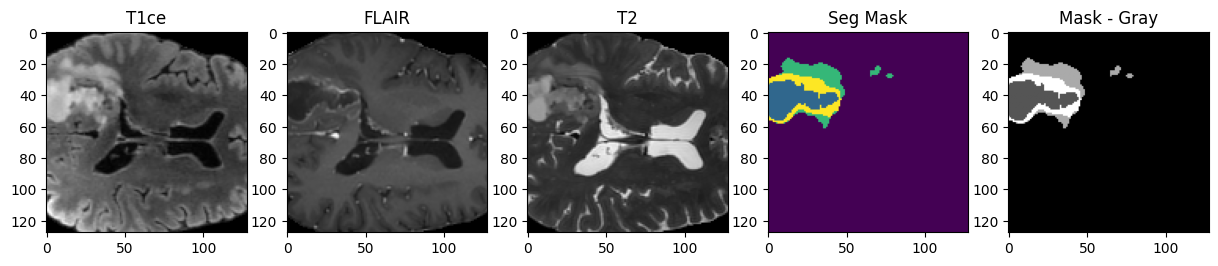

In [ ]:
def visualize_slices(images, masks, num_slices=20):
    batch_size = images.shape[0]

    masks = torch.argmax(masks, dim=1)  # along the channel/class dim

    for i in range(min(num_slices, batch_size)):
        fig, ax = plt.subplots(1, 5, figsize=(15, 5))

        middle_slice = images.shape[2] // 2
        ax[0].imshow(images[i, 0, middle_slice, :, :], cmap="gray")
        ax[1].imshow(images[i, 1, middle_slice, :, :], cmap="gray")
        ax[2].imshow(images[i, 2, middle_slice, :, :], cmap="gray")
        ax[3].imshow(masks[i, middle_slice, :, :], cmap="viridis")
        ax[4].imshow(masks[i, middle_slice, :, :], cmap="gray")

        ax[0].set_title("T1ce")
        ax[1].set_title("FLAIR")
        ax[2].set_title("T2")
        ax[3].set_title("Seg Mask")
        ax[4].set_title("Mask - Gray")

        plt.show()


visualize_slices(batch['image'], batch['label'], num_slices=20)

# Build the model architecture (class)

In [ ]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv3d(in_channels, out_channels, kernel_size = (3, 3, 1), padding = (1, 1, 0), stride = (1, 1, 1)),
      nn.BatchNorm3d(out_channels),
      nn.ReLU(inplace = True),
      nn.Dropout(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
      nn.Conv3d(out_channels, out_channels, kernel_size = (3, 3, 1), padding = (1, 1, 0), stride = (1, 1, 1)),
      nn.BatchNorm3d(out_channels),
      nn.ReLU(inplace = True)
  )
  return conv

class GridAttentionBlock(nn.Module):

  def __init__(self, in_channels, gating_channels, inter_channels):

    super().__init__()
    self.in_channels, self.gating_channels, self.inter_channels = in_channels, gating_channels, inter_channels
    self.theta = nn.Conv3d(in_channels = self.in_channels, out_channels = self.inter_channels, kernel_size = (2, 2, 2), stride = (2, 2, 2), padding = 0, bias = False)
    self.phi = nn.Conv3d(in_channels = self.gating_channels, out_channels = self.inter_channels, kernel_size = 1, stride = 1, padding = 0, bias = True)
    self.psi = nn.Conv3d(in_channels = self.inter_channels, out_channels = 1, kernel_size = 1, stride = 1, padding = 0, bias = True)
    self.W = nn.Sequential(
        nn.Conv3d(in_channels = self.in_channels, out_channels = self.in_channels, kernel_size = 1, stride = 1, padding = 0, bias = False),
        nn.BatchNorm3d(self.in_channels)
    )

  def forward(self, x, g):

    input_size = x.size()
    batch_size = input_size[0]
    assert batch_size == g.size(0)

    theta_x = self.theta(x)
    theta_x_size = theta_x.size()

    phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
    f = F.relu(theta_x + phi_g, inplace = True)

    sigm_psi_f = F.sigmoid(self.psi(f))

    sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')
    y = sigm_psi_f.expand_as(x) * x
    W_y = self.W(y)

    return W_y

class UpConv(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size = 2, stride = 2)
    self.conv = double_conv(in_channels, out_channels)

  def forward(self, x, y):
    x = self.upconv(x)
    cat = torch.cat([x, y], dim = 1)
    out = self.conv(cat)
    return out

class AttentionUNet3D(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    filters = [32, 64, 128, 256, 512]

    # contraction path
    self.conv1 = double_conv(in_channels = in_channels, out_channels=filters[0])
    self.pool1 = nn.MaxPool3d(kernel_size = 2)

    self.conv2 = double_conv(in_channels = filters[0], out_channels = filters[1])
    self.pool2 = nn.MaxPool3d(kernel_size = 2)

    self.conv3 =  double_conv(in_channels = filters[1], out_channels = filters[2])
    self.pool3 = nn.MaxPool3d(kernel_size = 2)

    self.conv4 = double_conv(in_channels = filters[2], out_channels = filters[3])
    self.pool4 = nn.MaxPool3d(kernel_size = 2)

    # bottleneck
    self.center = double_conv(in_channels = filters[3], out_channels = filters[4])
    self.gating = nn.Sequential(
        nn.Conv3d(in_channels = filters[4], out_channels = filters[4], kernel_size = 1, stride = 1, padding = 0),
        nn.BatchNorm3d(filters[4]),
        nn.ReLU(inplace = True)
    )

    # attention blocks
    self.attention4 = GridAttentionBlock(in_channels = filters[3], gating_channels = filters[4], inter_channels = filters[3])
    self.attention3 = GridAttentionBlock(in_channels = filters[2], gating_channels = filters[3], inter_channels = filters[2])
    self.attention2 = GridAttentionBlock(in_channels = filters[1], gating_channels = filters[2], inter_channels = filters[1])
    self.attention1 = GridAttentionBlock(in_channels = filters[0], gating_channels = filters[1], inter_channels = filters[0])

    # expansive path
    self.upconv4 = UpConv(in_channels = filters[4], out_channels = filters[3])
    self.upconv3 = UpConv(in_channels = filters[3], out_channels = filters[2])
    self.upconv2 = UpConv(in_channels = filters[2], out_channels = filters[1])
    self.upconv1 = UpConv(in_channels = filters[1], out_channels = filters[0])

    # final layer
    self.out_conv = nn.Conv3d(in_channels = filters[0], out_channels = out_channels, kernel_size = 1)

  def forward(self, x):

    # contracting path
    c1 = self.conv1(x) # shape of output tensor = 32 x 128 x 128 x 128
    p1 = self.pool1(c1) # shape of output tensor = 32 x 64 x 64 x 64

    c2 = self.conv2(p1) # shape of output tensor = 64 x 64 x 64 x 64
    p2 = self.pool2(c2) # shape of output tensor = 64 x 32 x 32 x 32

    c3 = self.conv3(p2) # shape of output tensor = 128 x 32 x 32 x 32
    p3 = self.pool3(c3) # shape of output tensor = 128 x 16 x 16 x 16

    c4 = self.conv4(p3) # shape of output tensor = 256 x 16 x 16 x 16
    p4 = self.pool4(c4) # shape of output tensor = 256 x 8 x 8 x 8

    # bottleneck
    center = self.center(p4) # shape of output tensor = 512 x 8 x 8 x 8
    # gating_signal = self.gating(center) # shape of output tensor = 512 x 8 x 8 x 8

    # expansive path
    g_conv4 = self.attention4(c4, center) # shape of output tensor = 256 x 16 x 16 x 16
    up_conv4 = self.upconv4(center, g_conv4) # shape of output tensor = 256 x 16 x 16 x 16

    g_conv3 = self.attention3(c3, up_conv4) # shape of output tensor = 128 x 32 x 32 x 32
    up_conv3 = self.upconv3(up_conv4, g_conv3) # shape of output tensor = 128 x 32 x 32 x 32

    g_conv2 = self.attention2(c2, up_conv3) # shape of output tensor = 64 x 64 x 64 x 64
    up_conv2 = self.upconv2(up_conv3, g_conv2) # shape of output tensor = 64 x 64 x 64 x 64

    g_conv1 = self.attention1(c1, up_conv2) # shape of output tensor = 32 x 128 x 128 x 128
    up_conv1 = self.upconv1(up_conv2, g_conv1) # shape of output tensor = 32 x 128 x 128 x 128

    outputs = self.out_conv(up_conv1) # shape of output tensor = 4 x 128 x 128 x 128
    return outputs

# Get an instance of the model

In [ ]:
model = AttentionUNet3D(in_channels=3, out_channels=4)
print(model)
model.to(device)

AttentionUNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv3d(64, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

AttentionUNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv3d(64, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

# Check the forward pass

In [ ]:
ip_tensor = torch.randn(1, 3, 128, 128, 128).to(device)
output = model(ip_tensor)
print(f"Input shape: {ip_tensor.shape}")
print(f"Output shape: {output.shape}")

# summary(model, input_size = (3, 128, 128, 128), batch_size = -1)


<ipython-input-11-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-11-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


Input shape: torch.Size([1, 3, 128, 128, 128])
Output shape: torch.Size([1, 4, 128, 128, 128])


In [ ]:
def create_checkpoint_dir(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    try:
        num_versions = [
            int(i.split("_")[-1]) for i in os.listdir(checkpoint_dir) if "version" in i
        ]
        version_num = max(num_versions) + 1

    except:
        version_num = 0

    version_dir = os.path.join(checkpoint_dir, "version_" + str(version_num))
    os.makedirs(version_dir)

    print(f"Checkpoint directory: {version_dir}")
    return version_dir

In [ ]:
ckpt_dir = create_checkpoint_dir(os.path.join('/content/drive/MyDrive/model_checkpoint', 'AttentionUNet3D_Brats2025'))

Checkpoint directory: /content/drive/MyDrive/model_checkpoint/AttentionUNet3D_Brats2025/version_1


# Define the loss functions

In [ ]:
# Define the loss function
import segmentation_models_pytorch_3d as smp
dice_loss = smp.losses.DiceLoss(
   mode="multiclass",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability
   ignore_index=None,          # Don't ignore any classes
   eps=1e-7                    # Epsilon for numerical stability
)

def combined_loss(logits, target):
  loss1 = dice_loss(logits, target)
  # loss2 = nn.CrossEntropyLoss()(logits, target)
  # return loss1 + loss2
  return loss1

# Define the optimizers, train and validation functions

In [ ]:
optimizer = Adam(model.parameters(), lr = 1e-4)

min_valid_loss = float("inf")

In [ ]:
def train_one_epoch(
   model,
   loader,
   optimizer,
   num_classes,
   device="cpu",
   epoch_idx=800,
   total_epochs=50):


   model.train()


   loss_record = MeanMetric()
   metric_record = MeanMetric()
   acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')  # Use macro-average accuracy

   loader_len = len(loader)

   with tqdm(total=loader_len, ncols=122) as tq:
       tq.set_description(f"Train ::  Epoch: {epoch_idx}/{total_epochs}")

       for batch in loader:
           tq.update(1)

           data, target = batch['image'].to(device).float(), batch['label'].to(device).float()

           optimizer.zero_grad()

           output_dict = model(data)

           target = target.argmax(dim=1)  # Convert one-hot to class indices

           clsfy_out = output_dict  # classifier head output

           loss = combined_loss(clsfy_out, target)

           # Calculate gradients w.r.t training parameters
           loss.backward()
           optimizer.step()

           # Detach for evaluation
           with torch.no_grad():
               pred_idx = clsfy_out.argmax(dim=1)

               # Calculate stats and IoU
               tp, fp, fn, tn = smp.metrics.get_stats(pred_idx, target, mode='multiclass', num_classes=num_classes)

               # Macro IoU and class-wise IoU
               metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

               acc_record.update(pred_idx.cpu(), target.cpu())
               loss_record.update(loss.detach().cpu(), weight=data.shape[0])
               metric_record.update(metric_macro.cpu(), weight=data.shape[0])

           tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, IoU: {metric_record.compute():.4f}, Acc: {acc_record.compute():.4f}")

   epoch_loss = loss_record.compute()
   epoch_metric = metric_record.compute()
   epoch_acc = acc_record.compute()

   return epoch_loss, epoch_metric, epoch_acc

In [ ]:
# Validation function, logging macro IoU and per-class IoU.
def validate(
   model,
   loader,
   device,
   num_classes,
   epoch_idx,
   total_epochs
):
   model.eval()


   loss_record = MeanMetric()
   metric_record = MeanMetric()
   acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')

   loader_len = len(loader)

   with tqdm(total=loader_len, ncols=122) as tq:
       tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")

       for data, target in loader:
           tq.update(1)

           data, target = batch['image'].to(device).float(), batch['label'].to(device).float()

           with torch.no_grad():
               output_dict = model(data)

           clsfy_out = output_dict
           target = target.argmax(dim=1)  # Convert one-hot to class indices

           loss = combined_loss(clsfy_out, target)
           pred_idx = clsfy_out.argmax(dim=1)

           tp, fp, fn, tn = smp.metrics.get_stats(pred_idx, target, mode='multiclass', num_classes=num_classes)

           # Macro IoU
           metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

           acc_record.update(pred_idx.cpu(), target.cpu())
           loss_record.update(loss.cpu(), weight=data.shape[0])
           metric_record.update(metric_macro.cpu(), weight=data.shape[0]) #data.shape = batch

       valid_epoch_loss = loss_record.compute()
       valid_epoch_metric = metric_record.compute()
       valid_epoch_acc = acc_record.compute()

   return valid_epoch_loss, valid_epoch_metric, valid_epoch_acc


# Train the model

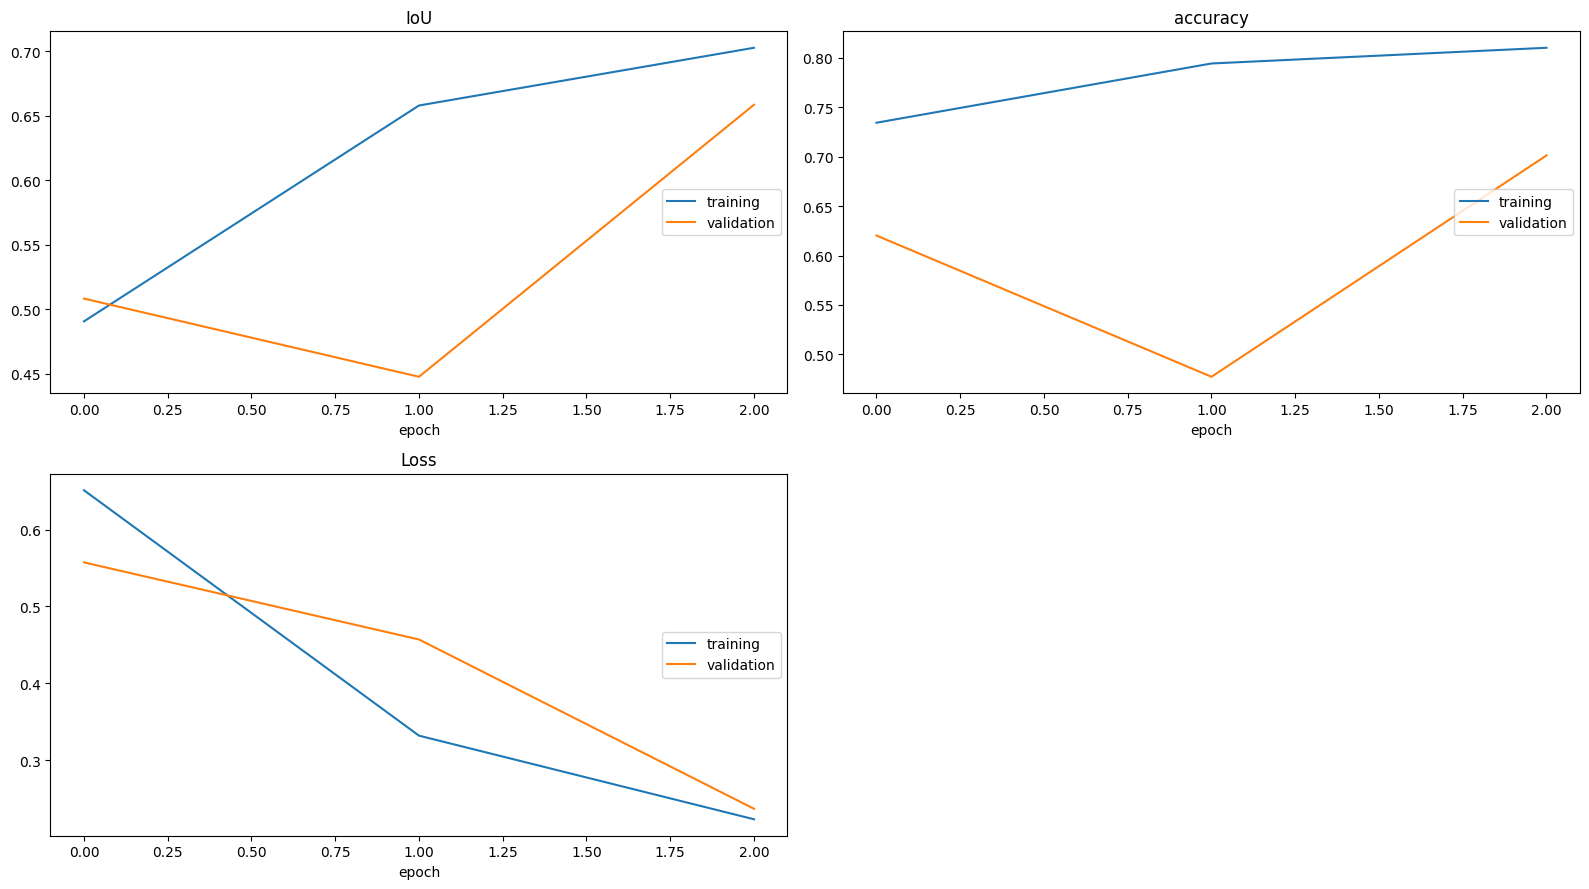

IoU
	training         	 (min:    0.490, max:    0.703, cur:    0.703)
	validation       	 (min:    0.447, max:    0.659, cur:    0.659)
accuracy
	training         	 (min:    0.734, max:    0.810, cur:    0.810)
	validation       	 (min:    0.477, max:    0.701, cur:    0.701)
Loss
	training         	 (min:    0.223, max:    0.651, cur:    0.223)
	validation       	 (min:    0.237, max:    0.557, cur:    0.237)
Model Improved. Saving...Done.



In [ ]:
total_epochs = 3

# Move model to the correct device before the loop starts
model.to(device, non_blocking=True)

writer = SummaryWriter(log_dir=os.path.join(ckpt_dir, "tboard_logs"))
best_loss = float("inf")
live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(8, 3)), ExtremaPrinter()])

for epoch in range(total_epochs):
    current_epoch = epoch + 1

    torch.cuda.empty_cache()
    gc.collect()

    # Train one epoch
    train_loss, train_metric, train_acc = train_one_epoch(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        num_classes=4,
        device=device,
        epoch_idx=current_epoch,
        total_epochs=total_epochs,
    )

    # Validate after each epoch
    valid_loss, valid_metric, valid_acc = validate(
        model=model,
        loader=val_loader,
        device=device,
        num_classes=4,
        epoch_idx=current_epoch,
        total_epochs=total_epochs,
    )

    # Update live plot
    live_plot.update(
        {
            "loss": train_loss,
            "val_loss": valid_loss,
            "accuracy": train_acc,
            "val_accuracy": valid_acc,
            "IoU": train_metric,
            "val_IoU": valid_metric,
        }
    )

    live_plot.send()

    # Write training and validation metrics to TensorBoard
    writer.add_scalar("Loss/train", train_loss, current_epoch)
    writer.add_scalar("Loss/valid", valid_loss, current_epoch)
    writer.add_scalar("Accuracy/train", train_acc, current_epoch)
    writer.add_scalar("Accuracy/valid", valid_acc, current_epoch)
    writer.add_scalar("IoU/train", train_metric, current_epoch)
    writer.add_scalar("IoU/valid", valid_metric, current_epoch)

    # Step the Cosine Annealing LR scheduler
    # scheduler.step()

    # Save the model if validation loss improves
    if valid_loss < best_loss:
        best_loss = valid_loss
        print("Model Improved. Saving...", end="")

        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "model": model.state_dict(),
        }
        torch.save(checkpoint_dict, os.path.join(ckpt_dir, "ckpt.tar"))
        del checkpoint_dict
        print("Done.\n")

writer.close()

In [ ]:
trained_model = AttentionUNet3D(in_channels = 3, out_channels = 4)
trained_model.load_state_dict(torch.load("/content/drive/MyDrive/model_checkpoint/AttentionUNet3D_Brats2025/version_1/ckpt.tar", map_location = "cpu")['model'])
trained_model.to(device)
trained_model.eval()

AttentionUNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv3d(64, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

# Evaluate the model

In [ ]:
@torch.inference_mode()
def inference(model, loader, device="cpu", num_batches_to_process=8):
    for idx, batch in enumerate(loader):

        # Move batch images to the device (CPU or GPU)
        batch_img = batch['image'].to(device).float()
        batch_mask = batch['label'].to(device).float()
        # Get the predictions from the model
        pred_all = model(batch_img)

        # Move the predictions to CPU and apply argmax to get predicted classes
        pred_all = pred_all.cpu().argmax(dim=1).numpy()
        # Optionally break after processing a fixed number of batches
        if idx == num_batches_to_process:
            break

        # Visualize images and predictions
        for i in range(0, len(batch_img)):
            fig, ax = plt.subplots(1, 5, figsize=(20, 8))
            middle_slice = batch_img.shape[2] // 2  # Along Depth
            # Visualize different modalities (e.g., T1ce, FLAIR, T2)
            ax[0].imshow(batch_img[i, 0, middle_slice, :, :].cpu().numpy(), cmap="gray")
            ax[1].imshow(batch_img[i, 1, middle_slice, :, :].cpu().numpy(), cmap="gray")
            ax[2].imshow(batch_img[i, 2, middle_slice, :, :].cpu().numpy(), cmap="gray")

            # Get the ground truth mask as class indices using argmax (combine all classes)
            gt_combined = (
                batch_mask[i, :, middle_slice, :, :].argmax(dim=0).cpu().numpy()
            )

            # Visualize the ground truth mask
            ax[3].imshow(gt_combined, cmap="viridis")
            ax[3].set_title("Ground Truth (All Classes)")
            # Visualize the predicted mask
            ax[4].imshow(pred_all[i, middle_slice, :, :], cmap="viridis")
            ax[4].set_title("Predicted Mask")

            # Set titles for the image subplot
            ax[0].set_title("T1ce")
            ax[1].set_title("FLAIR")
            ax[2].set_title("T2")

            # Turn off axis for all subplots
            for a in ax:
                a.axis("off")
            # Show the plot
            plt.show()


# Run inference
inference(model, val_loader, device="cuda", num_batches_to_process=12)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
save_path = "/content/drive/MyDrive//model_checkpoint/AttentionUNet3D_Brats2025/AttentionUNet3D_latest.pth"
torch.save(trained_model.state_dict(), save_path)

In [ ]:
# for epoch in range(NUM_EPOCHS):

#   train_loss = 0.0
#   model.train()
#   for i, batch in enumerate(train_loader):
#     image = batch['image'].to(device).float()
#     label = batch['label'].to(device).float()

#     optimizer.zero_grad()

#     output_dict = model(image)
#     target = target.argmax(dim = 1)
#     clsfy_out = output_dict
#     loss = combined_loss(clsfy_out, label)
#     loss.backward()
#     optimizer.step()

#     train_loss += loss.item()

#     # writer.add_scalar("Loss/Train", train_loss / len(train_loader), epoch)
#     print(f"Epoch {epoch + 1}\tTrainig Loss {i} / {len(train_loader)}: {loss.item()} ")

#     # perform testing on the validation set for every 100 batches
#     if i >= 100 and i % 100 == 0:
#       model.eval()
#       total_valid_loss = 0.0
#       for j, val_batch in enumerate(val_loader):
#         val_image = val_batch['image'].to(device)
#         val_label = val_batch['label'].to(device)

#         # get the predictions and compute loss
#         val_logits = model(val_image)
#         val_loss = combined_loss(val_logits, val_label)
#         total_valid_loss += val_loss.item()

#         if j % 10 == 0:
#           print(f"Epoch {epoch + 1}\tValidation Loss {j} / {len(val_loader)}: {val_loss.item()}")

#       if total_valid_loss < min_valid_loss:
#         print(f"Validation Loss Decreased from {min_valid_loss} to {total_valid_loss}. Saving the model...")
#         min_valid_loss = total_valid_loss
#         torch.save(model.state_dict(), "3D_UNET.pth")

## Metrics

In [ ]:
# ─── Load best model and set to eval ───────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet3D(in_channels=3, out_channels=4).to(device)

# load best weights
ckpt_path = "/content/drive/MyDrive/model_checkpoint/AttentionUNet3D_Brats2025/AttentionUNet3D_latest.pth"
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt)
model.eval()
print("Model loaded and set to eval()")


Model loaded and set to eval()


In [ ]:
# ─── Metric Helpers ───────────────────────────────────────────────────────────
import numpy as np

def center_crop_target(label, target_shape):
    *batch, H,W,D = label.shape
    tH,tW,tD    = target_shape
    sh,sw,sd    = (H-tH)//2, (W-tW)//2, (D-tD)//2
    slices     = [slice(None)]*len(batch) + [
        slice(sh,sh+tH), slice(sw,sw+tW), slice(sd,sd+tD)
    ]
    return label[tuple(slices)]

def compute_metrics_single(pred, label, num_classes=4):
    """Returns (mean_iou, accuracy, mean_dice) for one sample."""
    ious, dices = [], []
    acc = (pred == label).sum().item() / label.numel()
    for cls in range(num_classes):
        p = (pred==cls); g = (label==cls)
        inter = (p & g).sum().item()
        union = (p | g).sum().item()
        if union > 0:
            ious.append(inter/union)
            sum_pred  = p.sum().item()
            sum_label = g.sum().item()
            dices.append((2*inter) / (sum_pred + sum_label) if (sum_pred+sum_label)>0 else 0)
    mean_iou  = float(np.mean(ious))  if ious  else 0.0
    mean_dice = float(np.mean(dices)) if dices else 0.0
    return mean_iou, acc, mean_dice

In [ ]:
# ─── Evaluate on Validation Set (first 88 samples) ───────────────────────────
from tqdm import tqdm

val_iou, val_acc, val_dice = [], [], []
samples_processed = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        x = batch["image"].to(device).float()        # (B,3,128,128,128)
        y = batch["label"].to(device)       # (B,4,128,128,128) one‐hot

        logits = model(x)                   # (B,4,128,128,128)
        preds  = logits.argmax(dim=1)       # (B,128,128,128)

        # if shapes mismatch (due to padding/cropping), center‐crop the GT
        if preds.shape[1:] != y.shape[2:]:
            y = center_crop_target(y, preds.shape[1:])  # still one‐hot
        y_idx = y.argmax(dim=1)  # (B,128,128,128)

        # accumulate metrics per sample
        for p, g in zip(preds.cpu(), y_idx.cpu()):
            mi, ac, md = compute_metrics_single(p, g)
            val_iou.append(mi)
            val_acc.append(ac)
            val_dice.append(md)
            samples_processed += 1
            if samples_processed >= 88:
                break
        if samples_processed >= 88:
            break

# ─── Print Summary ────────────────────────────────────────────────────────────
print(f"Samples evaluated: {samples_processed}")
print(f"Mean IoU : {np.mean(val_iou ): .4f}")
print(f"Mean Acc : {np.mean(val_acc ): .4f}")
print(f"Mean Dice: {np.mean(val_dice): .4f}")

Validating:   0%|          | 0/251 [00:00<?, ?it/s]<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')
Validating:  35%|███▍      | 87/251 [03:19<06:16,  2.30s/it]

Samples evaluated: 88
Mean IoU :  0.6137
Mean Acc :  0.9401
Mean Dice:  0.7027


<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


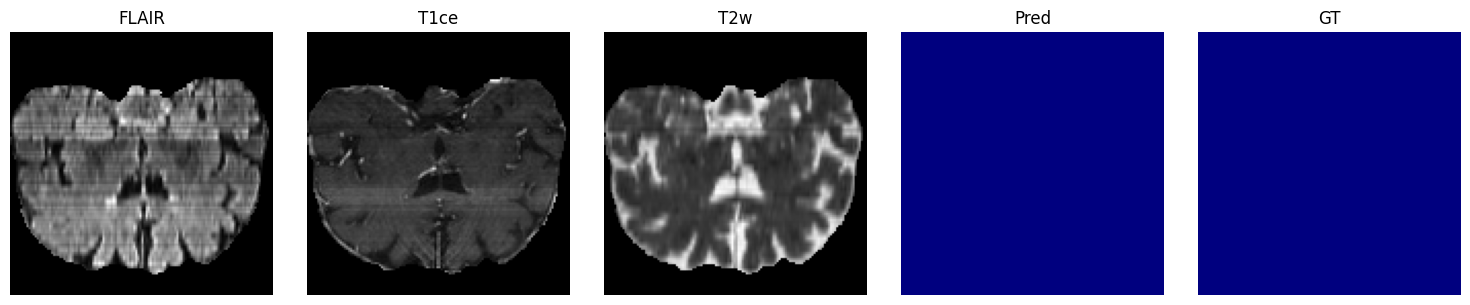

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


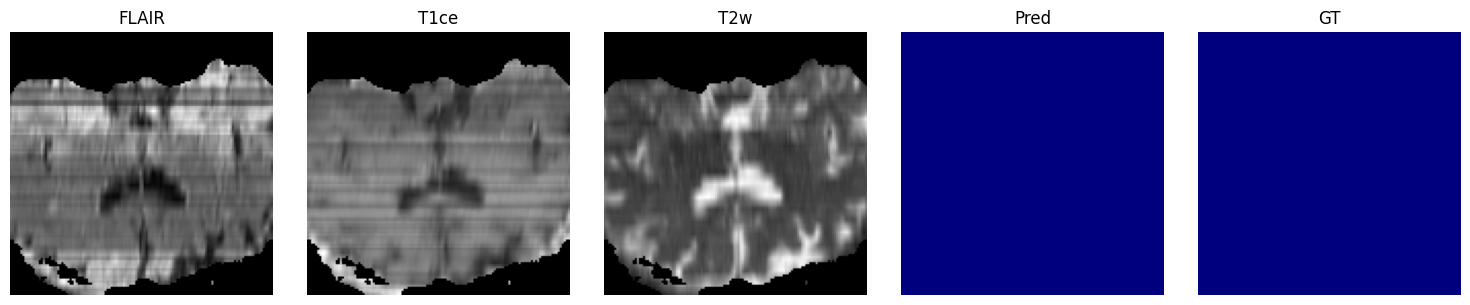

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


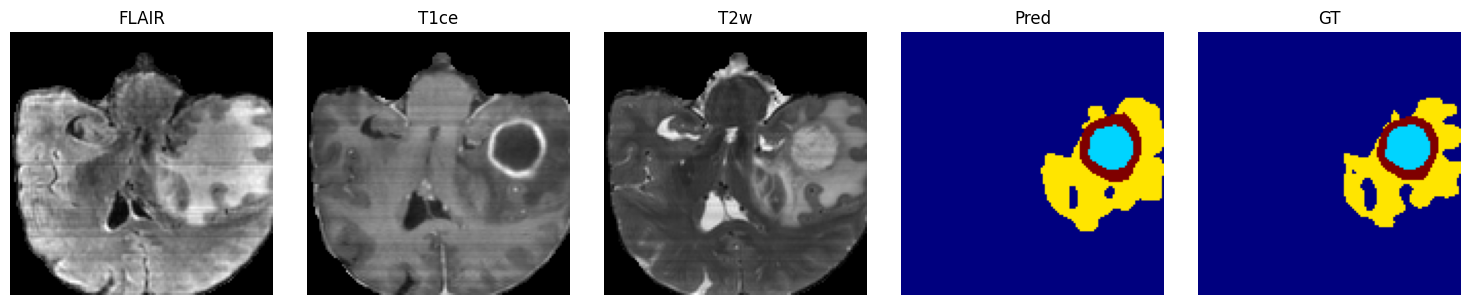

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


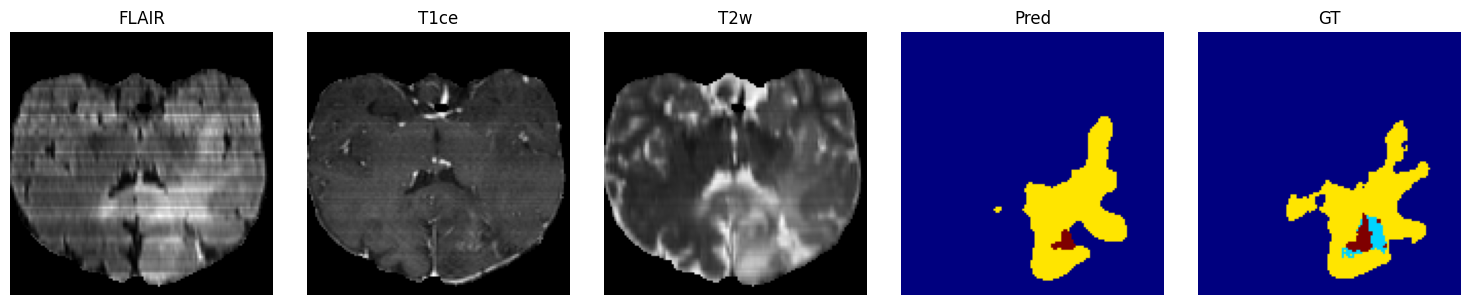

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


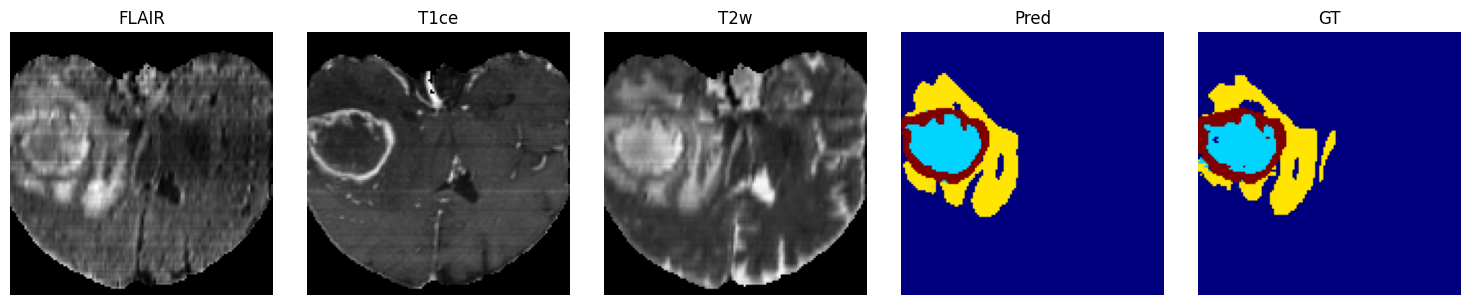

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


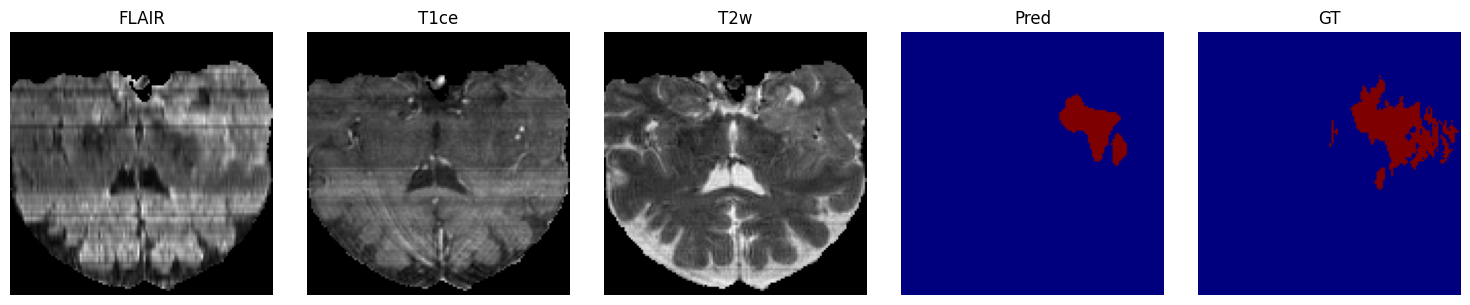

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


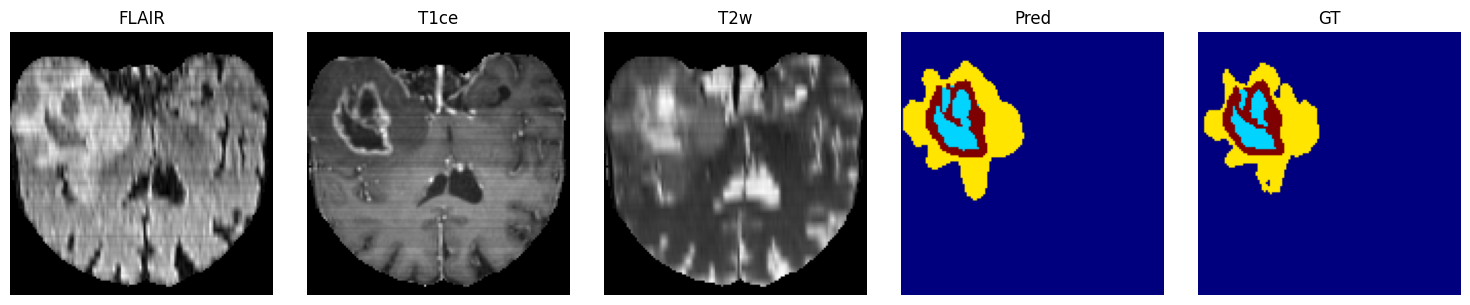

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


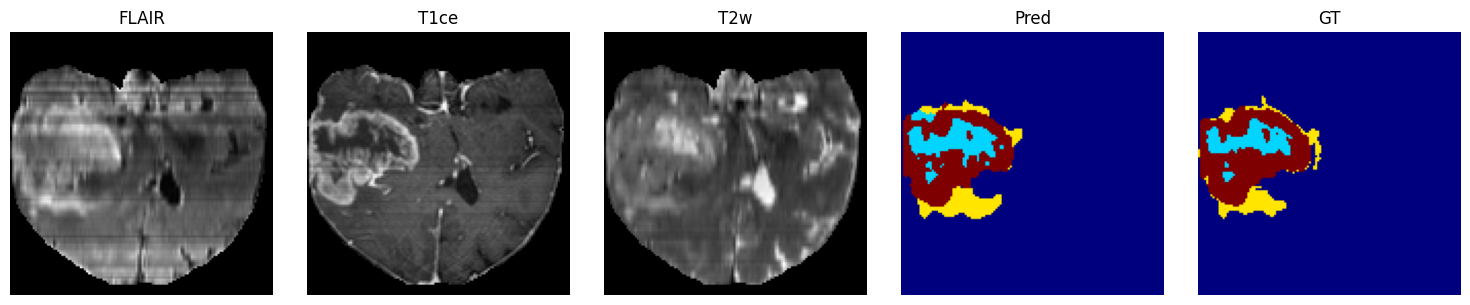

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


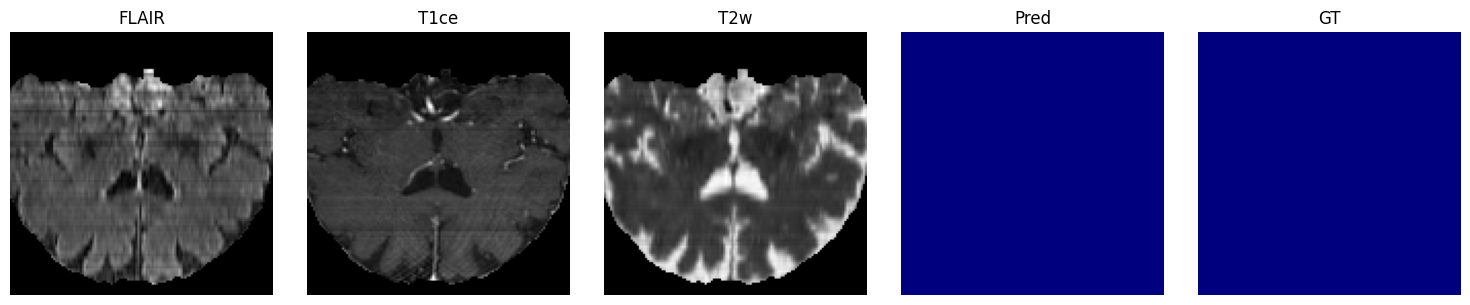

<ipython-input-7-7307e995b683>:36: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  phi_g = F.upsample(self.phi(g), size = theta_x_size[2:], mode = 'trilinear')
<ipython-input-7-7307e995b683>:41: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  sigm_psi_f = F.upsample(sigm_psi_f, size = input_size[2:], mode = 'trilinear')


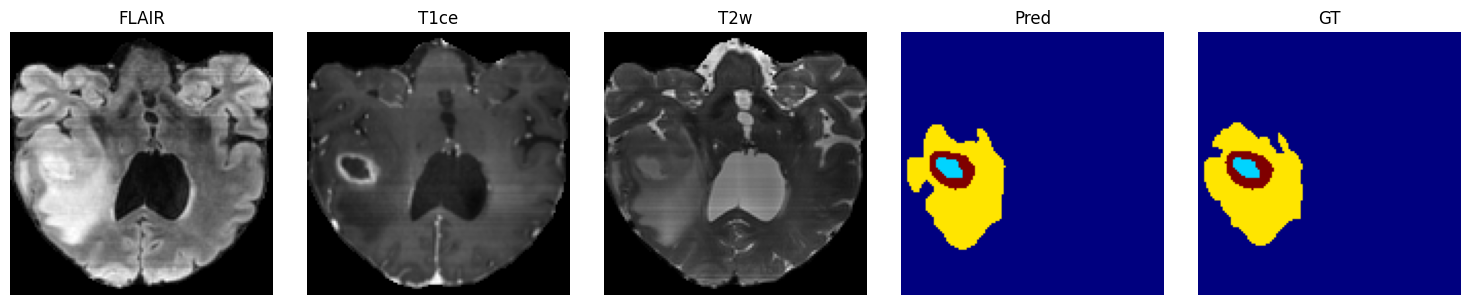

In [ ]:
# ─── Visualize a Few Random Validation Cases ──────────────────────────────────
import random
import matplotlib.pyplot as plt

# pick 10 random indices from the validation Subset
subset_len = len(val_dataset)
for idx in random.sample(range(subset_len), 10):
    sample = val_dataset[idx]              # Subset returns the raw dict
    img    = sample["image"].float()               # (3,128,128,128)
    gt_one = sample["label"]               # (4,128,128,128) one-hot
    gt_idx = gt_one.argmax(dim=0)          # (128,128,128)

    # model prediction
    with torch.no_grad():
        pred_idx = model(img.unsqueeze(0).to(device)) \
                      .argmax(dim=1)[0]     # (128,128,128)
        pred_idx = pred_idx.cpu()

    sl = img.shape[3] // 2                 # middle depth slice

    # Show 5 panels: 3 modalities + pred + gt
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    titles = ["FLAIR", "T1ce", "T2w", "Pred", "GT"]
    panels = [
        img[0,:,:,sl].numpy(),
        img[1,:,:,sl].numpy(),
        img[2,:,:,sl].numpy(),
        pred_idx[:,:,sl].numpy(),
        gt_idx[:,:,sl].numpy()
    ]
    cmaps = ["gray"]*3 + ["jet","jet"]

    for ax, im, ttl, cmap in zip(axes, panels, titles, cmaps):
        ax.imshow(im, cmap=cmap)
        ax.set_title(ttl)
        ax.axis("off")
    plt.tight_layout()
    plt.show()